In [20]:
import os
import anndata as ad
from scanpy import pp
from scanpy.tl import diffmap
import numpy as np
from numpy import random
import scipy as sp
from prosstt import tree
from prosstt import simulation as sim
from prosstt import sim_utils as sut
from scanpy.tl import umap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from prosstt import tree
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
#set random seed for reproducability
PATH = os.getcwd()
rseed = 1312
random.seed(rseed)
save = False


dataset_number = 2
topology_list = ['linear', 'binary', 'half']
topology = topology_list[dataset_number]
lengh_tree_liste = [254,8,21]
lenght_tree = lengh_tree_liste[dataset_number]

#
value = 0.1
modules = 10  # nb de programme genetique
modules = 50

draw = True
multi_draw = False


nb_genes = 50

value_list = [0.1,0.5,1.0]  # alpha in NB sampling


print('module:', modules, 'lenght of tree :', lenght_tree, 'nb_genes :', nb_genes, 'alpha_value :',value,  'topology :', topology)

module: 50 lenght of tree : 21 nb_genes : 50 alpha_value : 0.1 topology : half


In [21]:

number_tree = topology
nfactor = 11 # nb_sample_per_node = nfactor*10
name_tree = '_'+str(modules)+'_'+str(value)
name_file_to_save = PATH+'/data/final_Tree/'+str(topology)+'/'+str(lenght_tree)+'/'
if save :
    os.makedirs(name_file_to_save, exist_ok=True)



In [22]:
def create_tree(lenght=5, topology='binary') :

    list_edge = []
    dict_edges = {}


    if topology == 'binary' :
        list_of_nodes = [element for element in range(sum([2**i for i in range(lenght + 1)]))]

        #init
        dict_edges[list_of_nodes[0]] = [list_of_nodes[1], list_of_nodes[2]]
        list_edge.append([str(list_of_nodes[0]), str(list_of_nodes[1])])
        list_edge.append([str(list_of_nodes[0]), str(list_of_nodes[2])])

        for t in range(1,lenght) :

            nodes_parent = list_of_nodes[2**(t -1) -1 : 2**(t) -1 ]
            nodes = list_of_nodes[2**t -1 : 2**(t+1) -1 ]
            nodes_child = list_of_nodes[2 ** (t+1) - 1: 2 ** (t + 2) - 1]
            print(nodes_parent, nodes, nodes_child)

            for indice, node in enumerate(nodes) :
                liste_descendant = [nodes_child[2*indice], nodes_child[2*indice+1]]
                liste_ascendante = [nodes_parent[int(indice/2)]]
                dict_edges[node] = liste_descendant + liste_ascendante
                list_edge.append([str(node), str(nodes_child[2*indice])])
                list_edge.append([str(node), str(nodes_child[2 * indice+1]) ])

        for indice, node in enumerate(nodes):
            dict_edges[nodes_child[2 * indice]] = [node]
            dict_edges[nodes_child[2 * indice + 1]] = [node]

    if topology == 'linear':
        list_of_nodes = [i for i in range(lenght +1 )]
        
        #init
        dict_edges[list_of_nodes[0]] = [list_of_nodes[1]]
        list_edge.append([str(list_of_nodes[0]), str(list_of_nodes[1])])

        for t in range(1, lenght):
            
            nodes_parent = list_of_nodes[t-1]
            nodes = list_of_nodes[t]
            nodes_child = list_of_nodes[t+1]

            liste_of_neighboor = [nodes_parent, nodes_child]
            dict_edges[nodes] = liste_of_neighboor
            list_edge.append([str(nodes), str(nodes_child)])

        dict_edges[t] = [list_of_nodes[t -1],list_of_nodes[t + 1]]
        dict_edges[t+1] = [list_of_nodes[t]]

    if topology == 'half':
        list_of_nodes = [element for element in range(sum([1 + i for i in range(lenght + 1)]))]
        dict_edges = {}
        list_edge = []
        # init
        dict_edges[list_of_nodes[0]] = [list_of_nodes[1], list_of_nodes[2]]
        list_edge.append([str(list_of_nodes[0]), str(list_of_nodes[1])])
        list_edge.append([str(list_of_nodes[0]), str(list_of_nodes[2])])

        for t in range(1, lenght):
            nodes_parent = list_of_nodes[sum([1 + i for i in range(t - 1)]): sum([1 + i for i in range(t)])]
            nodes = list_of_nodes[sum([1 + i for i in range(t)]): sum([1 + i for i in range(t + 1)])]
            nodes_child = list_of_nodes[sum([1 + i for i in range(t + 1)]): sum([1 + i for i in range(t + 2)])]

            #print(nodes_parent, nodes, nodes_child)

            for indice, node in enumerate(nodes):
                if indice == 0:
                    liste_descendant = [nodes_child[indice], nodes_child[indice + 1]]
                    liste_ascendante = [nodes_parent[indice]]
                    list_edge.append([str(node), str(nodes_child[2 * indice])])
                    list_edge.append([str(node), str(nodes_child[2 * indice + 1])])
                if indice != 0:
                    liste_descendant = [nodes_child[indice + 1]]
                    if indice == 1:
                        liste_ascendante = [nodes_parent[int(indice / 2)]]
                    else:
                        liste_ascendante = [nodes_parent[indice - 1]]
                    list_edge.append([str(node), str(nodes_child[indice + 1])])

                dict_edges[node] = liste_descendant + liste_ascendante

        for indice, node in enumerate(nodes):
            if indice == 0:
                dict_edges[nodes_child[indice]] = [node]
            dict_edges[nodes_child[indice + 1]] = [node]

    return list_edge, dict_edges




In [23]:
list_edge, dict_edges = create_tree(lenght=lenght_tree, topology=topology)
print(dict_edges)
print(list_edge)

{0: [1, 2], 1: [3, 4, 0], 2: [5, 0], 3: [6, 7, 1], 4: [8, 1], 5: [9, 2], 6: [10, 11, 3], 7: [12, 3], 8: [13, 4], 9: [14, 5], 10: [15, 16, 6], 11: [17, 6], 12: [18, 7], 13: [19, 8], 14: [20, 9], 15: [21, 22, 10], 16: [23, 10], 17: [24, 11], 18: [25, 12], 19: [26, 13], 20: [27, 14], 21: [28, 29, 15], 22: [30, 15], 23: [31, 16], 24: [32, 17], 25: [33, 18], 26: [34, 19], 27: [35, 20], 28: [36, 37, 21], 29: [38, 21], 30: [39, 22], 31: [40, 23], 32: [41, 24], 33: [42, 25], 34: [43, 26], 35: [44, 27], 36: [45, 46, 28], 37: [47, 28], 38: [48, 29], 39: [49, 30], 40: [50, 31], 41: [51, 32], 42: [52, 33], 43: [53, 34], 44: [54, 35], 45: [55, 56, 36], 46: [57, 36], 47: [58, 37], 48: [59, 38], 49: [60, 39], 50: [61, 40], 51: [62, 41], 52: [63, 42], 53: [64, 43], 54: [65, 44], 55: [66, 67, 45], 56: [68, 45], 57: [69, 46], 58: [70, 47], 59: [71, 48], 60: [72, 49], 61: [73, 50], 62: [74, 51], 63: [75, 52], 64: [76, 53], 65: [77, 54], 66: [78, 79, 55], 67: [80, 55], 68: [81, 56], 69: [82, 57], 70: [83,

In [24]:

top = list_edge
branches = np.unique(np.array(top).flatten())
time = {b: nfactor*10 for b in branches}  #ce qui revient au nombre de cell généré car ça définit la densité dans le sampling
G = nb_genes
t = tree.Tree(topology=top, G=G, time=time, num_branches=len(branches), branch_points=1, modules=modules)


uMs, Ws, Hs = sim.simulate_lineage(t, intra_branch_tol=-1, inter_branch_tol=0)
gene_scale = sut.simulate_base_gene_exp(t, uMs)
t.add_genes(uMs, gene_scale)

mya = np.min([0.05, 1 / t.modules])
uMs, Ws, Hs = sim.simulate_lineage(t, a=mya, intra_branch_tol=-1, inter_branch_tol=0)
gene_scale = sut.simulate_base_gene_exp(t, uMs)
t.add_genes(uMs, gene_scale)

alpha = np.array([value]*t.G)
beta = np.array([1.5] * t.G)

X, labs, brns, scalings = sim.sample_whole_tree(t, n_factor=nfactor, alpha=alpha, beta=beta)
X = (X.transpose() / scalings).transpose()

br_names, indices = np.unique(brns, return_inverse=True)



/home/malek/anaconda3/lib/python3.8/site-packages/prosstt-1.2.0-py3.8.egg/prosstt/simulation.py:153: UserWarning: No argument 'a' specified in kwargs: using gamma and a=0.04
/home/malek/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


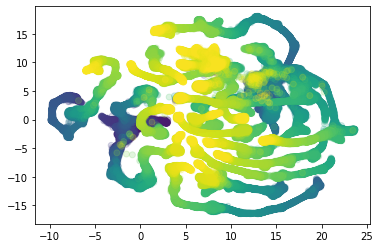

In [37]:


if draw :
    data = ad.AnnData(np.log(X + 1))
    pp.neighbors(data, use_rep='X')
    umap(data)
    dm = data.obsm["X_umap"]
    fig = plt.figure()
    dm = data.obsm["X_umap"]
    br_names, indices = np.unique(brns, return_inverse=True)
    plt.scatter(dm[:, 0], dm[:, 1], c=labs, alpha=0.2)
    plt.show()
    if save : 
        plt.savefig(name_file_to_save+'X_Tree'+str(name_tree)+'.jpeg')



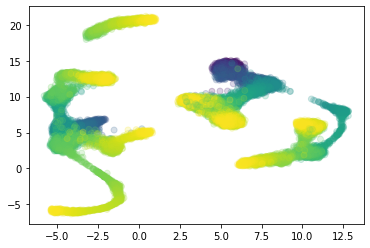

In [7]:
# dm = data.obsm["X_umap"]
# fig = plt.figure()
# dm = data.obsm["X_umap"]
# br_names, indices = np.unique(brns, return_inverse=True)
# plt.scatter(dm[:, 0], dm[:, 1], c=labs, alpha=0.2)
# if save : 
#         plt.savefig(name_file_to_save+'X_Tree'+str(name_tree)+'+-'+str(value)+'.jpeg')

In [8]:

if multi_draw :
    fig, ax = plt.subplots(nrows=1,ncols=2)

    for v,value in enumerate([0.1, 1]):
        alpha = np.array([value]*t.G)
        beta = np.array([value*10]*t.G)
        beta = np.array([1.5] * t.G)
        X, labs, brns, scalings = sim.sample_whole_tree(t, n_factor=nfactor, alpha=alpha, beta=beta)
        # normalize gene expression by library size
        X = (X.transpose() / scalings).transpose()
        data = ad.AnnData(np.log(X+1))
        pp.neighbors(data, use_rep='X')
        umap(data)
        dm = data.obsm["X_umap"]
        br_names, indices = np.unique(brns, return_inverse=True)

        #ax[0][v].scatter(dm[:, 0], dm[:, 1], c=indices, alpha=0.2)
        ax[v].scatter(dm[:, 0], dm[:, 1], c=labs, alpha=0.2)

    if save :
        plt.savefig(name_file_to_save+'X_Tree'+str(number_tree)+'+-'+str(value)+'.jpeg')
    plt.show()
    #np.save(name_file_to_save+'X_Tree'+str(number_tree)+'+-', X)

In [25]:

set_names = br_names.tolist()
X, y = X, brns


In [26]:
def BFS_SP(graph, start, goal):
    explored = []
    queue = [[start]]
    if start == goal:
        print("Same Node")
        return
    while queue:
        path = queue.pop(0)
        node = path[-1]
        if node not in explored:
            neighbours = graph[node]
            for neighbour in neighbours:
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)
                if neighbour == goal:
                    return len(new_path) - 1
    print("So sorry, but a connecting path doesn't exist :(")
    return explored

def create_matrix_from_dic(dic):
    names_genea = sorted(list(set(list(sorted(dic.keys())))))
    c = len(dic)
    mat_adj = np.zeros((c, c))
    for i in range(c):
        for j in dic[names_genea[i]]:
            index_j = names_genea.index(j)
            mat_adj[i, index_j] = 1

    list_exception = np.where(mat_adj - mat_adj.T > 0)

    mat_dist = np.zeros((c, c))
    for i in range(c):
        for j in range(i + 1, c):
            mat_dist[i, j] = BFS_SP(dic, names_genea[i], names_genea[j])


    return mat_adj, mat_dist + mat_dist.T


In [27]:
liste_edges = t.topology
liste_neighboors = [[element[0]  for element in liste_edges  if (key in element[1]) ] + [element[1]  for element in liste_edges  if (key in element[0]) ]   for key in br_names]
#dict_edges_bis = dict(zip(br_names,liste_neighboors))

In [28]:
import networkx as nx
def create_C(dict_edges):
    G = nx.Graph(dict_edges)
    nodes = list(G.nodes)
    c = len(nodes)
    mat_dist = np.zeros((c, c))
    for i in range(c):
        for j in range(i + 1, c):
            mat_dist[i, j] = len(nx.shortest_path(G, source=i, target=j)) -1
    return mat_dist + mat_dist.T


In [29]:
mat_dist = create_C(dict_edges)

In [30]:
mat_dist[1]

array([ 1.,  0.,  2.,  1.,  1.,  3.,  2.,  2.,  2.,  4.,  3.,  3.,  3.,
        3.,  5.,  4.,  4.,  4.,  4.,  4.,  6.,  5.,  5.,  5.,  5.,  5.,
        5.,  7.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  9.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8., 10.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
       11., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 12.,
       11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 13.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       14., 13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 13.,
       13., 13., 15., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14.,
       14., 14., 14., 14., 14., 16., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 17., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 18., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17

In [31]:
print(X.shape)
print(len(y))
print(mat_dist.shape)
#print(nfactor)

#nb sample per label, it should be close to 1200 for partial label train test split
print([list(y).count(str(c)) for c in range(10)])


(306130, 50)
306130
(253, 253)
[1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210]


In [32]:
print(list(y).count('0'))

1210


In [33]:
save = True
name_tree = '_'+str(modules)+'_'+str(value)+'_nfactor_'+str(nfactor)
name_tree

'_50_0.1_nfactor_11'

In [17]:
if save :
    np.save(name_file_to_save+'X_Tree'+str(name_tree), X)
    np.save(name_file_to_save+'y_Tree'+str(name_tree), y)
    np.save(name_file_to_save+'Tree'+str(name_tree)+'_mat_dist', mat_dist)
    np.save(name_file_to_save+'Tree'+str(name_tree)+'_pseudotime', labs)